In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test['id']

In [3]:
print(train.head())
print(train.describe())
print(train.isnull().sum())

   id  temperature  irradiance            humidity  panel_age  \
0   0     7.817315  576.179270   41.24308670850264  32.135501   
1   1    24.785727  240.003973  1.3596482765960705  19.977460   
2   2    46.652695  687.612799   91.26536837560256   1.496401   
3   3    53.339567  735.141179   96.19095521176159  18.491582   
4   4     5.575374   12.241203  27.495073003585226  30.722697   

   maintenance_count  soiling_ratio    voltage   current  module_temperature  \
0                4.0       0.803199  37.403527  1.963787           13.691147   
1                8.0       0.479456  21.843315  0.241473           27.545096   
2                4.0       0.822398  48.222882  4.191800           43.363708   
3                3.0       0.837529  46.295748  0.960567           57.720436   
4                6.0       0.551833   0.000000  0.898062            6.786263   

   cloud_coverage          wind_speed            pressure string_id  \
0       62.494044   12.82491203459621  1018.8665053152533

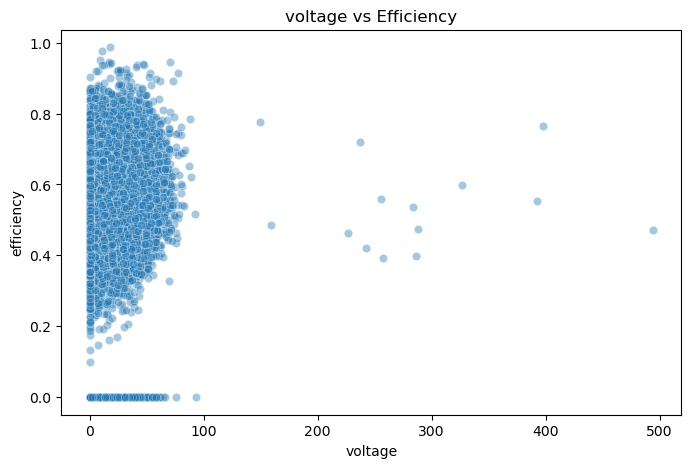

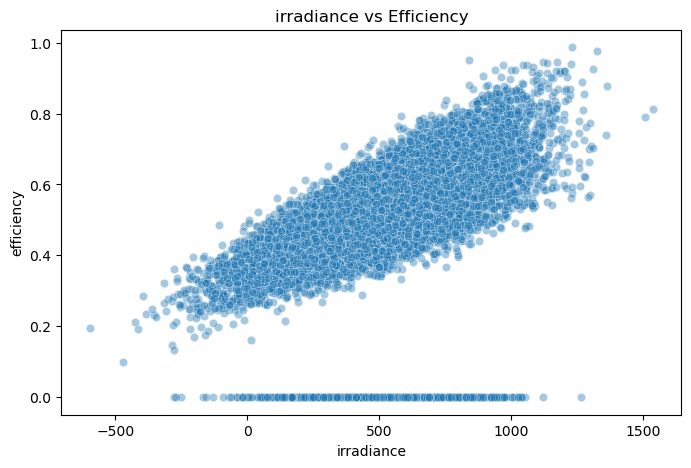

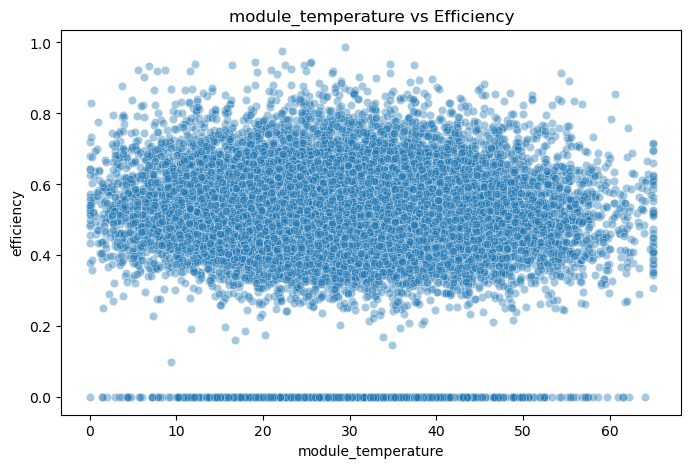

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["voltage", "irradiance", "module_temperature"]

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=train, x=feature, y="efficiency", alpha=0.4)
    plt.title(f"{feature} vs Efficiency")
    plt.show()

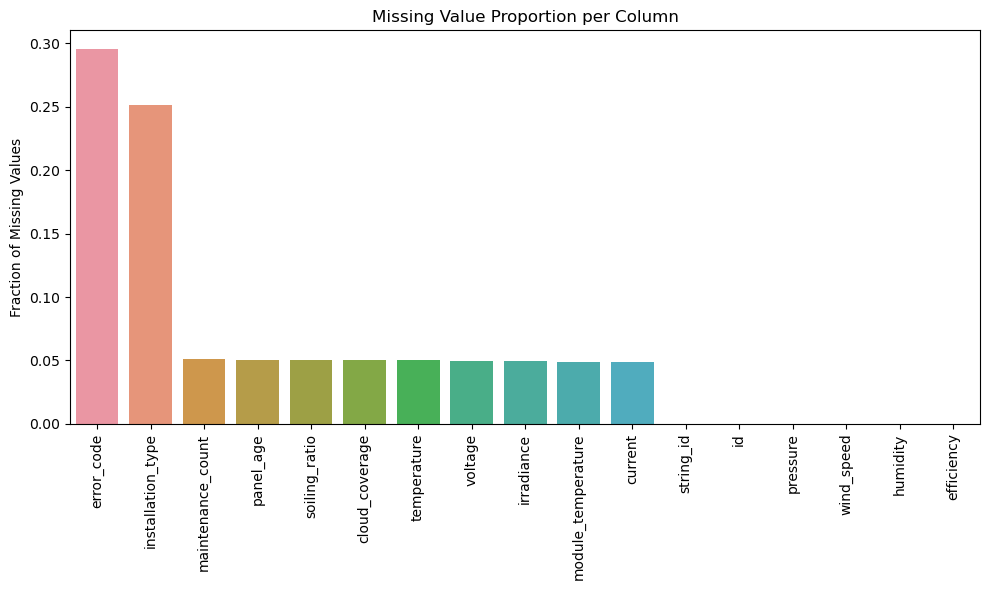

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot missing values
missing = train.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.title("Missing Value Proportion per Column")
plt.ylabel("Fraction of Missing Values")
plt.tight_layout()
plt.show()

In [6]:
# Drop physically impossible values
train = train[train['irradiance'] >= 0]

In [7]:
# Drop physically invalid irradiance
train = train[train['irradiance'] >= 0]

# Add a binary flag: is efficiency zero?
train['is_eff_zero'] = (train['efficiency'] == 0).astype(int)

# Fill missing categorical values with 'Unknown'
train['error_code'] = train['error_code'].fillna("Unknown")
train['installation_type'] = train['installation_type'].fillna("Unknown")

# Fill numeric columns with median
num_cols = ['temperature', 'irradiance', 'panel_age', 'maintenance_count', 'soiling_ratio', 'voltage', 'current', 'module_temperature', 'cloud_coverage']
for col in num_cols:
    train[col] = train[col].fillna(train[col].median())

In [8]:
print("String ID:")
print(train['string_id'].value_counts(), end='\n\n')

print("Error Code:")
print(train['error_code'].value_counts(), end='\n\n')

print("Installation Type:")
print(train['installation_type'].value_counts())

String ID:
D4    4718
B2    4668
C3    4644
A1    4559
Name: string_id, dtype: int64

Error Code:
E00        5559
Unknown    5504
E01        3828
E02        3698
Name: error_code, dtype: int64

Installation Type:
tracking     4698
Unknown      4688
fixed        4653
dual-axis    4550
Name: installation_type, dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
cat_cols = ['string_id', 'error_code', 'installation_type']

for col in cat_cols:
    le = LabelEncoder()
    
    # Combine both train and test values to avoid unseen values in test
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

In [10]:
num_missing_cols = train.columns[train.isnull().sum() > 0].tolist()
num_missing_cols = [col for col in num_missing_cols if col not in ['error_code', 'installation_type']]
for col in num_missing_cols:
    median_val = train[col].median()
    train[col] = train[col].fillna(median_val)
    test[col] = test[col].fillna(median_val)

In [13]:
X = train.drop(columns=['id', 'efficiency'])
y = train['efficiency']

In [14]:
# Find all non-numeric values in your feature data
non_numeric_cells = []

for col in X.columns:
    for i, val in enumerate(X[col]):
        try:
            float(val)
        except:
            non_numeric_cells.append((col, i, val))

# Show first few problematic cells
print(f"Found {len(non_numeric_cells)} non-numeric cells.\n")
for col, i, val in non_numeric_cells[:10]:
    print(f"Row {i}, Column '{col}' → Value: {val}")

Found 350 non-numeric cells.

Row 584, Column 'humidity' → Value: error
Row 879, Column 'humidity' → Value: error
Row 1077, Column 'humidity' → Value: error
Row 1170, Column 'humidity' → Value: error
Row 1422, Column 'humidity' → Value: error
Row 1504, Column 'humidity' → Value: unknown
Row 1623, Column 'humidity' → Value: badval
Row 2264, Column 'humidity' → Value: unknown
Row 2267, Column 'humidity' → Value: badval
Row 2406, Column 'humidity' → Value: badval


In [15]:
# Convert 'humidity' to numeric, coercing errors into NaN
X['humidity'] = pd.to_numeric(X['humidity'], errors='coerce')

# Fill NaNs with median humidity value
X['humidity'].fillna(X['humidity'].median(), inplace=True)

In [16]:
test['humidity'] = pd.to_numeric(test['humidity'], errors='coerce')
test['humidity'].fillna(test['humidity'].median(), inplace=True)

In [17]:
# Fix ALL columns: convert to numeric where possible, else NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill all remaining NaNs with median of each column
X.fillna(X.median(), inplace=True)

In [18]:
# object type columns to be converted
cols_to_convert = ['wind_speed', 'pressure', 'humidity']

for col in cols_to_convert:
    # Convert to numeric, coerce errors to NaN (so that 'error' or 'badval' become NaN)
    train[col] = pd.to_numeric(train[col], errors='coerce')

In [19]:
# Check how many NaNs resulted
print(train[cols_to_convert].isnull().sum())

# Fill NaNs
for col in cols_to_convert:
    median_value = train[col].median()
    train[col].fillna(median_value, inplace=True)

wind_speed    108
pressure      127
humidity      115
dtype: int64


In [20]:
# Model - Randomforest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X = train.drop(columns=['id', 'efficiency'])
y = train['efficiency']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

val_preds = rf.predict(X_val)
rmse = mean_squared_error(y_val, val_preds, squared=False)

print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.0428


In [22]:
score = rf.score(X_val, y_val)
print(f"R² score: {score:.4f}")

R² score: 0.9116
